In [17]:
import pandas as pd
import pretty_midi
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Load CSV containing MIDI file paths
csv_file = "maestro-v3.0.0/maestro-v3.0.0.csv"  # Change this to your actual file
df = pd.read_csv(csv_file)

# Define the base path for MIDI files
midi_base_path = "maestro-v3.0.0/"  # Change this to your dataset location

# Extract file paths
midi_files = df["midi_filename"].apply(lambda x: os.path.join(midi_base_path, x))

In [22]:
def midi_to_piano_roll(midi_path, fs=100):
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)
        piano_roll = midi.get_piano_roll(fs)  # fs = frame rate per second
        return piano_roll
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None

# Process a sample MIDI file
sample_piano_roll = midi_to_piano_roll(midi_files.iloc[0])
print("Piano roll shape:", sample_piano_roll.shape)  # (128, time_steps)

Piano roll shape: (128, 70398)


In [25]:
sequence_length = 100  # Number of time steps per training sequence

def create_sequences(piano_roll, sequence_length):
    X, y = [], []
    for i in range(piano_roll.shape[1] - sequence_length):
        X.append(piano_roll[:, i:i + sequence_length])
        y.append(piano_roll[:, i + sequence_length])  # Next timestep as label
    return np.array(X), np.array(y)

# Create training sequences from all MIDI files
X_all, y_all = [], []

for midi_file in midi_files[:100]:  # Use a subset for testing
    piano_roll = midi_to_piano_roll(midi_file)
    if piano_roll is not None:
        X, y = create_sequences(piano_roll, sequence_length)
        X_all.append(X)
        y_all.append(y)

# Convert lists to numpy arrays
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Transpose to (num_samples, time_steps, features)
X_all = np.transpose(X_all, (0, 2, 1))  # Shape: (num_samples, 100, 128)

print("Final shape of X:", X_all.shape)

MemoryError: Unable to allocate 6.70 GiB for an array with shape (70298, 128, 100) and data type float64

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_piano_roll = scaler.fit_transform(piano_roll.T).T  # Normalize across time steps


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(None, 128)),
    LSTM(256, return_sequences=True),
    Dense(128, activation='softmax')  # Predicting 128 piano roll values
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         394240    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 dense (Dense)               (None, None, 128)         32896     
                                                                 
Total params: 952,448
Trainable params: 952,448
Non-trainable params: 0
_________________________________________________________________


In [11]:
import numpy as np

# Define sequence length (e.g., 100 time steps)
sequence_length = 100

def create_sequences(piano_roll, sequence_length=100):
    X, y = [], []
    for i in range(piano_roll.shape[1] - sequence_length):
        X.append(piano_roll[:, i:i + sequence_length])
        y.append(piano_roll[:, i + sequence_length])  # Next timestep as label
    return np.array(X), np.array(y)

# Example: Extract sequences from a sample piano roll
X_train, y_train = create_sequences(piano_roll, sequence_length)
print("Training shape:", X_train.shape, y_train.shape)  # Expected: (num_samples, 128, sequence_length)

Training shape: (70298, 128, 100) (70298, 128)


In [13]:
X_train = np.transpose(X_train, (0, 2, 1))  # Swap time_steps and features
y_train = np.transpose(y_train, (0, 1))  # Make sure labels match new shape

In [14]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50


ValueError: in user code:

    File "C:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\HP\anaconda3\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 128) and (None, 100, 128) are incompatible


Total MIDI files: 0
Total MIDI files: 1276


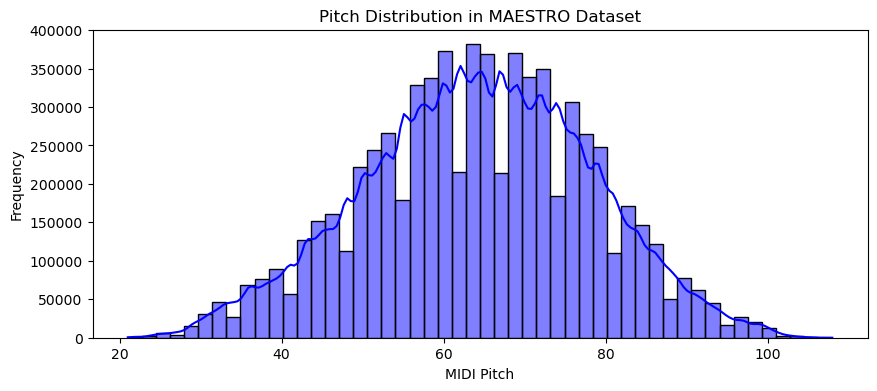

MemoryError: Unable to allocate 49.7 MiB for an array with shape (128, 50865) and data type float64

In [27]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load MAESTRO Dataset (Example Path)
dataset_path = "maestro-v3.0.0"
midi_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.midi') or f.endswith('.mid')]

# Display number of MIDI files available
print(f"Total MIDI files: {len(midi_files)}")
# Function to find all MIDI files in the directory and its subdirectories
def find_midi_files(dataset_path):
    midi_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.midi') or file.endswith('.mid'):
                midi_files.append(os.path.join(root, file))
    return midi_files

# Load all MIDI files from dataset path and subdirectories
midi_files = find_midi_files(dataset_path)

# Display the number of MIDI files found
print(f"Total MIDI files: {len(midi_files)}")


# Function to extract MIDI note sequences
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            notes.append([note.start, note.end, note.pitch, note.velocity])
    return np.array(notes)

# Process all MIDI files
all_notes = [midi_to_notes(f) for f in midi_files]
all_notes = np.concatenate(all_notes, axis=0)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 4))
sns.histplot(all_notes[:, 2], bins=50, kde=True, color="blue")
plt.xlabel("MIDI Pitch")
plt.ylabel("Frequency")
plt.title("Pitch Distribution in MAESTRO Dataset")
plt.show()

# Convert MIDI to piano roll representation
def midi_to_piano_roll(midi_file, fs=100):
    pm = pretty_midi.PrettyMIDI(midi_file)
    piano_roll = pm.get_piano_roll(fs=fs)
    return piano_roll.T  # Transpose for proper time-step format

piano_rolls = [midi_to_piano_roll(f) for f in midi_files]

# Define maximum sequence length and pad sequences
max_length = 1000
piano_rolls = [x[:max_length] if x.shape[0] > max_length else np.pad(x, ((0, max_length - x.shape[0]), (0, 0))) for x in piano_rolls]

# Convert to NumPy array
X = np.array(piano_rolls)

# Data Splitting (Train, Validation, Test)
X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Normalize input data
X_train = X_train / 127.0  # MIDI velocities range from 0-127
X_val = X_val / 127.0
X_test = X_test / 127.0

# Define LSTM-based Music Generation Model
model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(max_length, X_train.shape[2])),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(X_train.shape[2], activation='sigmoid')
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, X_train, epochs=50, validation_data=(X_val, X_val), batch_size=16)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate Music Sequence
generated_sequence = model.predict(X_test[:1])  # Generate for one test sample

# Convert generated sequence to MIDI
def piano_roll_to_midi(piano_roll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    for time, pitch_vector in enumerate(piano_roll):
        for pitch, velocity in enumerate(pitch_vector):
            if velocity > 0:
                note = pretty_midi.Note(
                    velocity=int(velocity * 127),
                    pitch=pitch,
                    start=time / fs,
                    end=(time + 1) / fs
                )
                instrument.notes.append(note)
    pm.instruments.append(instrument)
    return pm

generated_midi = piano_roll_to_midi(generated_sequence[0])
generated_midi.write("generated_music.mid")

# Plot Training Loss and Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()